<a href="https://colab.research.google.com/github/johnsocf/CSCI_3202_HW_5/blob/master/hw5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 2.x

In [2]:
%%capture
!pip install scikit-plot

In [3]:
import os, sys
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import pandas as pd
import numpy as np
import math
import cv2 as cv
import matplotlib.patches as patches
import statistics
import json
import glob
import scikitplot as skplt

#sci kit learn packages
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve,roc_auc_score
from sklearn.model_selection import train_test_split

# keras packages
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.callbacks import TensorBoard
from keras.models import Sequential
from keras import backend as K
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras.layers.experimental.preprocessing import CenterCrop
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.initializers import he_normal
from keras.layers import (BatchNormalization, Conv2D, Dense, Dropout, Flatten,
                          MaxPool2D, ReLU)
from keras.optimizers import Adam

# additional packages
from google.colab import files
from time import time
from PIL import Image
from operator import itemgetter
from matplotlib.pyplot import imread
from glob import glob

# 1.1 Import Competition Data from Kaggle

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
%%capture
!pip install kaggle
!pip install --upgrade kaggle

In [8]:
%%capture
!pip install --upgrade --force-reinstall --no-deps kaggle

In [9]:
!mkdir .kaggle

In [10]:
!mkdir .kaggle
!ls -a

mkdir: cannot create directory ‘.kaggle’: File exists
.  ..  .config	drive  .kaggle	sample_data


In [11]:
token = {"username":"catnippsunn","key":"d10a25e54993332212ca4e9f6a8dece2"}


In [12]:
!mkdir .kaggle
!ls -a

mkdir: cannot create directory ‘.kaggle’: File exists
.  ..  .config	drive  .kaggle	sample_data


In [13]:
# !cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json

In [17]:
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)

In [18]:
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json

In [19]:
!kaggle config set -n path -v{/content}

- path is now set to: {/content}


In [20]:
!chmod 600 /root/.kaggle/kaggle.json

In [21]:
import glob
files = glob.glob('/content/*')
for f in files:
    print('f: ', f)
    if os.path.isfile(f):
        os.remove(f)

f:  /content/drive
f:  /content/sample_data


In [22]:
!kaggle competitions download -c histopathologic-cancer-detection -p /content

100% 6.29G/6.31G [02:18<00:00, 51.0MB/s]
100% 6.31G/6.31G [02:18<00:00, 49.0MB/s]


In [27]:
!unzip \*.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/fa2c546059bd262cbe954dfdba24dc0d67f598b0.tif  
  inflating: train/fa2c657eff58b6802cb32843caa2fac25b67c2c9.tif  
  inflating: train/fa2c775c4457d0aeb7e57216849eef5f4e72e566.tif  
  inflating: train/fa2c77e1707c2fe7b0016e00736fb6e4b7f09488.tif  
  inflating: train/fa2ce5e802dd281bd98fcfb538e80b9c96c2b7af.tif  
  inflating: train/fa2d24e4a109d2d3a925890aaed4e0f038dfffb0.tif  
  inflating: train/fa2d7e4865aa7869d2dd85116323b8405c94f1c2.tif  
  inflating: train/fa2d8b2e4acf46e278e2e7acbc034c263d970737.tif  
  inflating: train/fa2df9148831509a181797db79eb1a7bf39593f1.tif  
  inflating: train/fa2e6db0b35484797f58005e3a6e24ca75fbca76.tif  
  inflating: train/fa2e80e84594465329bdc0c8d1b3a507275fbb4d.tif  
  inflating: train/fa2eaf8ec6267fa928a88775dc15ee25b633c537.tif  
  inflating: train/fa2ebf31ff5954570526d4835ac5368fabc1f035.tif  
  inflating: train/fa2efd2dda5235a3e397ea0dd637ea13a78f7599.tif  
  inflating: train/fa2f1d

# Set up Data Path Configs

In [28]:
# set useful paths to image and label directories for succinct use in the notebook
model_path = '.'
path = '/content/'
train_folder = '{}train'.format(path)
test_folder = '{}train'.format(path)
train_folder_cr = '{}train_cropped'.format(path)
test_folder_cr = '{}train_cropped'.format(path)
train_label = '{}train_labels.csv'.format(path)
sample_submission = '{}sample_submission.csv'.format(path)
input_test = '{}test'.format(path)

In [29]:
directory_for_training = train_folder
directory_for_testing = test_folder
data_shape = (96, 96, 3)
dims = (data_shape[0], data_shape[1])

Set up variables based on defaults for data directory paths and shapes.  This allows for easy configuration in the model building fitting. 

In [30]:
# configs used in model training and fit with cropped images.
directory_for_training_cr = train_folder_cr
directory_for_testing_cr = test_folder_cr
data_shape_cr = (32, 32, 3)
dims_cr = (data_shape[0], data_shape[1])

In [31]:
label_data_df = pd.read_csv(train_label)
label_data_df["file_name"] = label_data_df["id"].apply(lambda x: x + ".tif")

sample_size = 80000
id_label_pos = label_data_df.loc[label_data_df["label"] == 1, :].sample(n=sample_size)
id_label_neg = label_data_df.loc[label_data_df["label"] == 0, :].sample(n=sample_size)
id_label = pd.concat([id_label_pos, id_label_neg], ignore_index=True)
del id_label_pos, id_label_neg

id_label_train, id_label_val = train_test_split(id_label, test_size=0.1, stratify=id_label["label"])
id_label_train.reset_index(drop=True, inplace=True)
id_label_val.reset_index(drop=True, inplace=True)
len_train = id_label_train.shape[0]
len_val = id_label_val.shape[0]
print("Training Data Size: {}.".format(len_train))
print("Testing Data Size: {}.".format(len_val))
print("Label Data Size: {}.".format(label_data_df.size))
print("Percentage of Data Used: {}%.".format(round(((len_train + len_val)/label_data_df.size) * 100), 2))
del id_label

Training Data Size: 144000.
Testing Data Size: 16000.
Label Data Size: 660075.
Percentage of Data Used: 24.0%.


In [32]:
# TODO: Is using more data adventageous to the model?

# 1.2 Add an augmented copy of the dataset
## Add an additional Directory containing a copy of the Images with a Centered 32 x 32 Crop

This workbook will explore image cropping as an alternate option when providing data to train the model.  To do this each image is loaded, cropped, then saved with the same name to a new directory specific for croppped images.  A parallel model will train against one with the original images for analysis and comparison.

In [33]:
# add new directories in which to store cropped images.
!mkdir train_cropped
!mkdir test_cropped

In [34]:
# cropping images to middle 32 x 32 section where tumor would lie. (from known (96,96) height/width.)
# this test case involved setting image sizes to 32 x 32 instead of 96 x 96 in the keras model
# and updating the directory to use the test _res directories.
import glob

# clean up anything existing in the file into which cropped images will go.
files = glob.glob(train_folder_cr + '/*')
for f in files:
    os.remove(f)

start_width, start_height = (96, 96)
new_width, new_height = (32, 32)
# Set coords.  To get center crop is the following math.
left_coord = (start_width - new_width)//2
top_coord = (start_height - new_height)//2
right_coord = (start_width + new_width)//2
bottom_coord = (start_height + new_height)//2

# crop function, iterates through each item in the directory.
# uses python image module PIL.  ref: https://pillow.readthedocs.io/en/stable/reference/Image.html
# crops each image and saves it in a directory
def crop_images(dirs, start_path, dest_path):
    for item in dirs:
        # if os.path.isfile(start_path+ '/' + item):
        im = Image.open(start_path+'/' + item)
        # splits text into root path and file extension (f and e)
        # f, e = os.path.splitext(start_path+'/' + item)
        # f_1, e_1 = os.path.splitext(dest_path+'/' + item)
        im_crop = im.crop((left_coord, top_coord, right_coord, bottom_coord))
        # resize the for matching with the original data to allow 
        # use of the same architecture
        im_resize = im_crop.resize((96, 96))
        im_resize.save(dest_path + '/' + item)

# repeat for training images.
dirs_train = os.listdir(train_folder)
crop_images(dirs_train, train_folder, train_folder_cr)


##**Set up Data Viz functionality.**

#code for displaying Data Viz:

1.  Histogram is defined for data investigation.

2.  Sample images are pulled out to display visual differences in images positive for cancerous tumor and those negative for a cancerous tumor.  This may give further idea of the visual distinction between classes.  The insight can be used to better understand correlation between feature size and CNN model architecture.
Label data has an image number associated with positive (1) and negative (0) samples.  The ID associated with the sample in each label data item will map to an image in the train folders.  This image can be read and stored for printing to the screen.

3.  Using the RGB channel, determine the mean colors and most seen colors per image and display a plot for them.  This may show a consistency in the colors found in the data in positive and negative samples, and should be considered relevant to overfitting in analysis.  Since training on RGB color scale could be a feature that could skew the results and be unreplicatable in potential future samples used with the model to determine predictions.  (i.e. purple tinged samples may be more representative of positive samples, while pink may be representative of negative samples in the data).

1.  Histogram Display Code.

In [35]:
# store function for data viz distribution histogram, used below.
def define_histogram(data, range, title, x_axis_label, y_axis_label, ax, graphType=""):
    colors = ['r', 'g', 'b']
    counts, bins, p = ax.hist(data, range = range, bins=2, label="yellow", edgecolor='white', linewidth=1)
    p[0].set_facecolor('b')
    p[1].set_facecolor('y')
    ax.set_xticks(bins)
    ax.annotate('Negative', xy=(.5, 0), xycoords=('data', 'axes fraction'),
    xytext=(0, -18), textcoords='offset points', va='top', ha='center')
    ax.annotate('Positive', xy=(1.5, 0), xycoords=('data', 'axes fraction'),
    xytext=(0, -18), textcoords='offset points', va='top', ha='center')
    plt.title(title, fontsize=20)
    plt.xlabel(x_axis_label)
    plt.ylabel(y_axis_label)
    

2.  Sample image procurement code.

In [36]:
# loc gets rows from a pandas df given a certain set of conditions.
positive_image_sample_array = []
negative_image_sample_array = []
positive_image_samples = label_data_df.loc[label_data_df['label'] == 1].sample(6)
negative_image_samples = label_data_df.loc[label_data_df['label'] == 0].sample(6)

def parse_out_opened_samples(image_samples, opened_sample_array):
  for sample in image_samples['id']:
    path = os.path.join(train_folder, sample + '.tif')
    # cv2 open cv is a library for computer vision which provides an api for
    # reading an image file into an 2D array.
    img = cv.imread(path)
    # RAM space allow for storing a few images
    opened_sample_array.append(img)

parse_out_opened_samples(positive_image_samples, positive_image_sample_array)
parse_out_opened_samples(negative_image_samples, negative_image_sample_array)


3.  Image display code for sample images.

In [37]:
def show_image_samples(images, title, axis, r):
  for i,img in enumerate(images):
    axis[r,i].imshow(img)
    rect = patches.Rectangle((32,32),32,32,linewidth=4,edgecolor='w',facecolor='none', linestyle=':', capstyle='round')
    axis[r,i].add_patch(rect)
    axis[r,i].set_xticklabels([])
    axis[r,i].set_yticklabels([])
  axis[r,0].set_ylabel(title, size='large')

def show_image_samples_cropped(images, title, axis, r):
  for i,img in enumerate(images):
    axis[r,i].imshow(img)
  axis[r,0].set_ylabel(title, size='large')

4.  Average and Prominent Color Depictions.
The code credit reference for this snippet which was adapted for the specifics of this purpose is from:
https://stackoverflow.com/questions/43111029/how-to-find-the-average-colour-of-an-image-in-python-with-opencv.  
Explanations of the code are included.

In [38]:
avg_colors_pos = []
avg_colors_neg = []


def show_colors(color_image, img_type, plot_title):
    # get the average color from each channel
    average = color_image.mean(axis=0).mean(axis=0)
    # get average patch color from average by filling new image size with avg.
    average_color_block = np.ones(shape=color_image.shape, dtype=np.uint8)*np.uint8(average)
    # parse average color mean into positive or negative set.
    if img_type == 'pos':
        avg_colors_pos.append(average)
    else:
        avg_colors_neg.append(average)

    num_clusters = 5
    num_attempts = 10
    # reshape pixels into the same shape as the image
    pixels = np.float32(color_image.reshape(-1, 3))
    # stops iteration when maximum accuracy or iterations are reached
    criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 200, .1)
    # show initial centers
    flags = cv.KMEANS_RANDOM_CENTERS

    # run k means for clustering to get dominant pallet
    x, labels, cluster_centers = cv.kmeans(pixels, num_clusters, None, criteria, num_attempts, flags)
    x, counts = np.unique(labels, return_counts=True)

    # build an array to draw to with each frequent color (specified 5 in cv.kmeans)
    indi = np.argsort(counts)[::-1]  
    # sum stacked arrays with frequency of colors
    freqs = np.cumsum(np.hstack([[0], counts[indi]/float(counts.sum())]))
    # draw the row based on frequency
    rows = np.int_(color_image[0].shape[0]*freqs)

    # initialize dominant color block to zeros
    dominant_color_blocks = np.zeros(shape=color_image.shape, dtype=np.uint8)
    # fill rows from cluster center indices
    for i in range(len(rows) - 1):
        dominant_color_blocks[rows[i]:rows[i + 1], :, :] += np.uint8(cluster_centers[indi[i]])

    # show average and dominant color patches using matplotlib.
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12,6))
    fig.suptitle(plot_title,fontsize=20)
    ax0.imshow(average_color_block)
    ax0.set_title('Average color')
    ax1.imshow(dominant_color_blocks)
    ax1.set_title('Dominant colors')
    ax0.axis('off')
    ax1.axis('off')
    plt.show(fig)
    
def show_image_colors(data, title, ax):
    ax.imshow(data)
    ax.set_title(title)
    ax.axis('off')

# 1.3 Data Exploration
## image labels

Investigate data distribution of positive and negative samples within data.  It is evident that out of over 220K samples, about 60% of the samples are negative and 40% are positive.  The lack of consistent samples in each binary category may leave the CNN susceptable for overfitting, so additional measures to prevent this will be addressed in data preprocessing.  I used this info ensure that I properly utilized the training data to split it evently into a set with a positive result and a set with a negative result for the purpose of binary classification with as much accuracy as possible.

In [39]:
print(label_data_df['label'].value_counts(normalize=True))
print(label_data_df.head())
label_data_df.describe()
print('')
print('Number of training images : ', len(label_data_df))
pos = round(sum(label_data_df['label'].values)/len(label_data_df), 2) * 100
neg = round((100 - pos), 2)
print('Ratio of positive to negative samples: ', "%d:%d" % (pos, neg))
test_img = plt.imread("/content/train/"+label_data_df.iloc[0]['id']+'.tif')
print('Images shape (M, N, d) where d = RGB value channels', test_img.shape)

0    0.594969
1    0.405031
Name: label, dtype: float64
                                         id  ...                                     file_name
0  f38a6374c348f90b587e046aac6079959adf3835  ...  f38a6374c348f90b587e046aac6079959adf3835.tif
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77  ...  c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif
2  755db6279dae599ebb4d39a9123cce439965282d  ...  755db6279dae599ebb4d39a9123cce439965282d.tif
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08  ...  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif
4  068aba587a4950175d04c680d38943fd488d6a9d  ...  068aba587a4950175d04c680d38943fd488d6a9d.tif

[5 rows x 3 columns]

Number of training images :  220025
Ratio of positive to negative samples:  41:59
Images shape (M, N, d) where d = RGB value channels (96, 96, 3)


# 2 Data Viz:  
## 2.1 Histogram Distribution

A data vis using matplot library to show a histogram of the positive and negative sample ration within the dataset depicts in further detail the binary ratio of samples mentioned from the descriptive data set stats previously.  This visually depicts the skew'd ratio tending towards more negative samples in the dataset, which could lead towards false negatives.

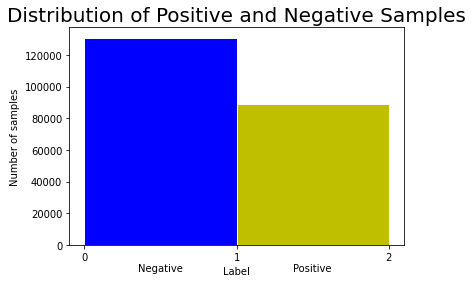

In [40]:
# utilize binary histogram function above.
fig, ax = plt.subplots()    
define_histogram(label_data_df.label, (0, 2), 'Distribution of Positive and Negative Samples', 'Label', 'Number of samples', ax)
plt.show()

## Image Samples

The following plots show the visual difference in positive and negative image samples, looking at the original 96 x 96 image as well as a center cropped version which isolates the patch where the cancerous tumor can be found that defines an image positive for the presence of cancer.  These depictions show just how feasible it is to determine this cancer given a naked eye.  The cancerous cell can be as small as 1px evident.  The model will be trained on both cropped and uncropped images to deduce if having more of the presence of outerlying cell data will add features to the CNN that become important.  Theoretically since the cropped version is closely contains the relevant information and nothing more, it will relevant for training to set up the model before gathering predictions from the model.

The following plots are a good check for seeing that the cropped images are correctly centered on the middle of the 32 x 32 square.

## 2.2 Cropped And Original Image Samples

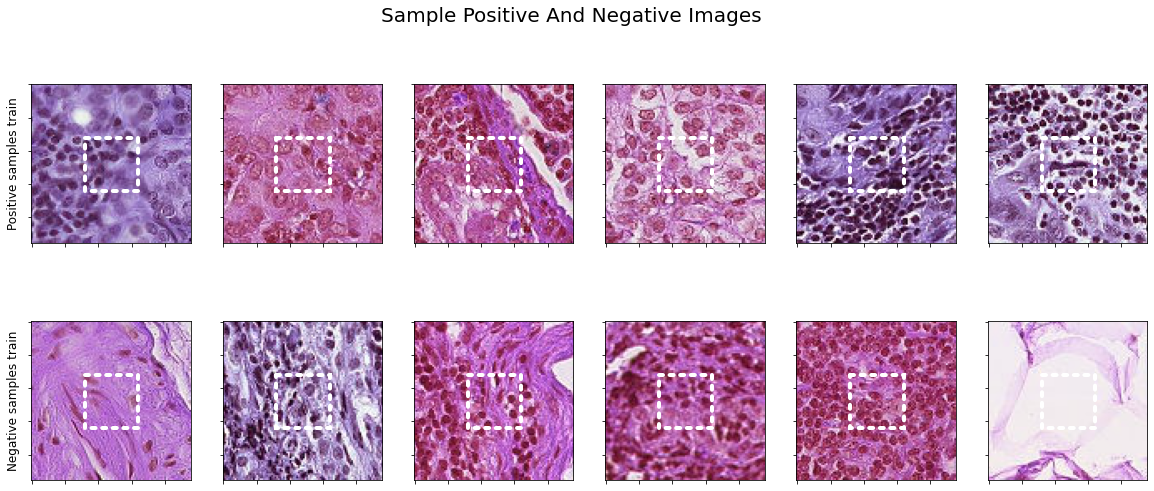

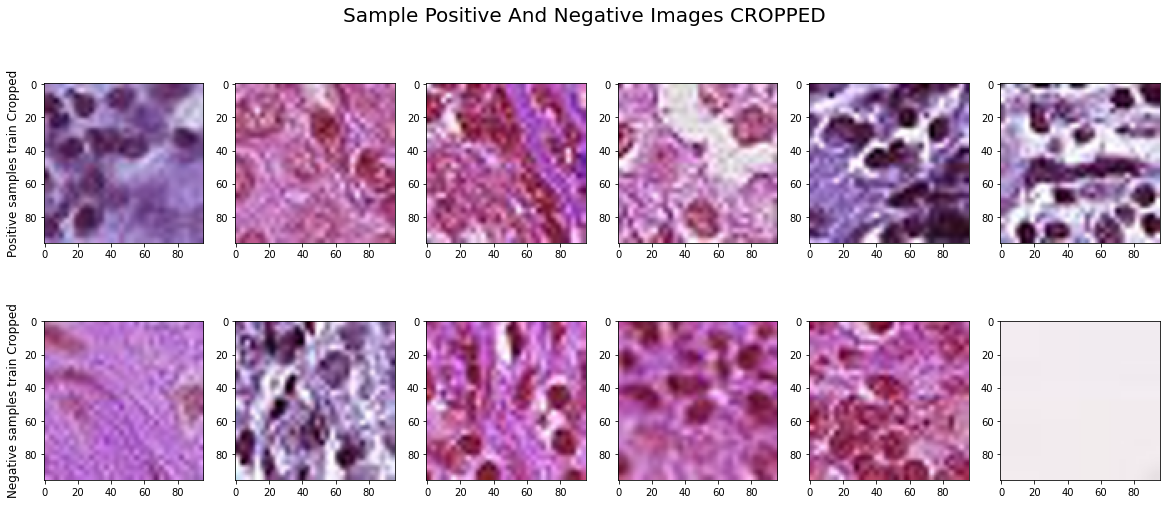

In [41]:
fig, ax0 = plt.subplots(2,6,figsize=(20,8))
fig.suptitle('Sample Positive And Negative Images',fontsize=20)
show_image_samples(positive_image_sample_array, 'Positive samples train', ax0, 0)
show_image_samples(negative_image_sample_array, 'Negative samples train', ax0, 1)

# loc gets rows from a pandas df given a certain set of conditions.
positive_image_sample_array_t = []
negative_image_sample_array_t = []
for sample in positive_image_samples['id']:
    path = os.path.join(train_folder_cr, sample + '.tif')
    # cv2 open cv is a library for computer vision which provides an api for
    # reading an image file into an 2D array.
    img = cv.imread(path)
    # RAM space allow for storing a few images
    height, width, channels = img.shape
    # debugger: print('shape', height, width, channels)
    positive_image_sample_array_t.append(img)
        
# repeat for negative samples
for sample in negative_image_samples['id']:
    path = os.path.join(train_folder_cr, sample + '.tif')
    img = cv.imread(path)
    height, width, channels = img.shape
    # debugger: print('shape', height, width, channels)
    negative_image_sample_array_t.append(img)

fig, ax0 = plt.subplots(2,6,figsize=(20,8))
fig.suptitle('Sample Positive And Negative Images CROPPED',fontsize=20)
show_image_samples_cropped(positive_image_sample_array_t, 'Positive samples train Cropped', ax0, 0)
show_image_samples_cropped(negative_image_sample_array_t, 'Negative samples train Cropped', ax0, 1)
   

## 2.3 Color Trends in Image Samples
Displaying Average and Dominent Colors in Positive and Negative Samples.  There are immediately evident consistencies but not direct parallels within each binary classification group.  This visualization assumes the image subsamples are representative of the whole since they have been selected randomly.  The image subsamples are consistent with those depicted in the sample images, above.

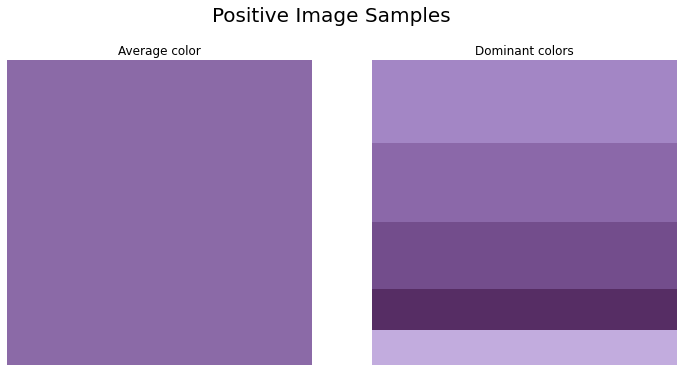

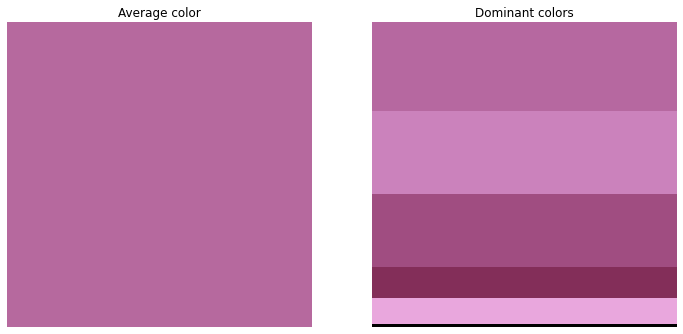

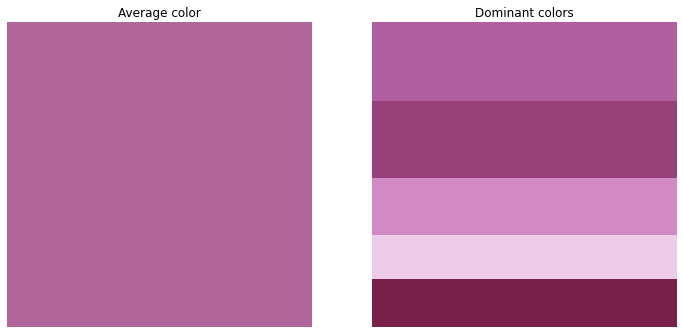

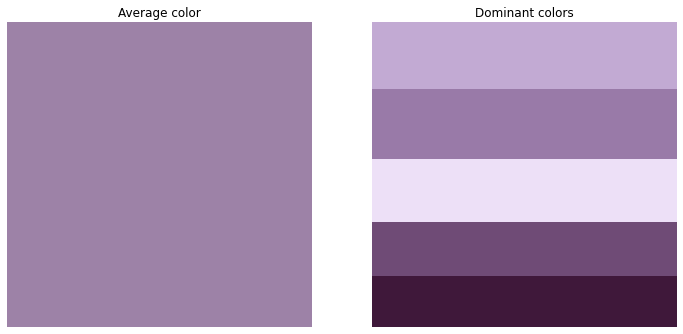

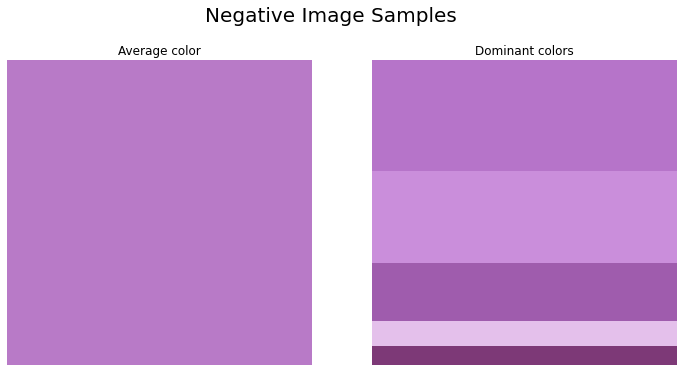

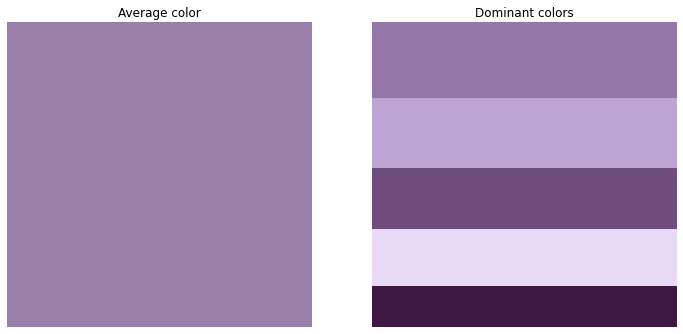

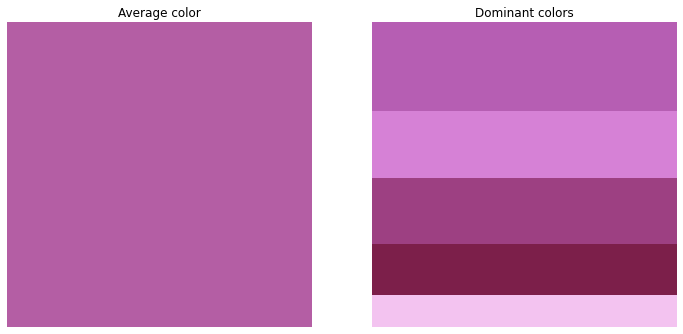

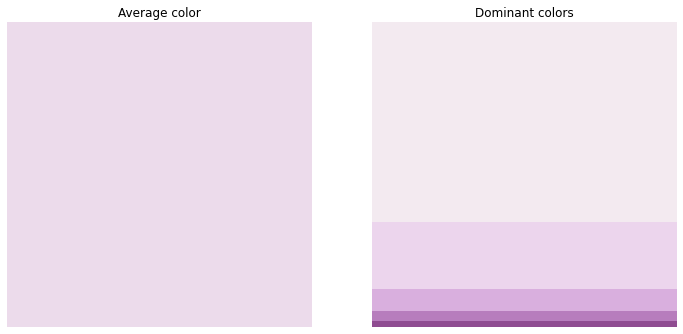

In [42]:
show_colors(positive_image_sample_array[0], 'pos', 'Positive Image Samples')
show_colors(positive_image_sample_array[1], 'pos', '')
show_colors(positive_image_sample_array[2], 'pos', '')
show_colors(positive_image_sample_array[len(positive_image_sample_array)-1], 'pos', '')
show_colors(negative_image_sample_array[0], 'neg', 'Negative Image Samples')
show_colors(negative_image_sample_array[1], 'neg', '')
show_colors(negative_image_sample_array[2], 'neg', '')
show_colors(negative_image_sample_array[len(negative_image_sample_array)-1], 'neg', '')

# 3 Data Cleaning and Augmentation.

## 3.1 Labels Dataframe Preprocessing

The Binary Class Mode in Keras preprocessing requires classes to be Strings.  This necessitates a translation from the stored data set which has classes stored as 0 and 1 format to represent negative and positive images, respectively.
Ref: https://keras.io/api/preprocessing/image/

The image ID in the label data set needs to also be adjusted to include the file extension since the mapping of ID will be used directly look up the image in the training and verification directories subsequent steps to set up the CNN.

In [43]:
# update labels since `class_mode='binary' requires classes to be strings.
id_label_train['label'] = np.where(id_label_train['label'] == 0, 'neg','pos')
id_label_val['label'] = np.where(id_label_val['label'] == 0, 'neg','pos')
# update image IDs to include the .tif file format for proper processing in
# subsequent steps.
id_label_train['id'] = id_label_train['id'] + '.tif'
id_label_val['id'] = id_label_val['id'] + '.tif'

In [44]:
id_label_val.head()

,id,label,file_name
0,f851ad31fd251b190da42556da658d471d141a37.tif,neg,f851ad31fd251b190da42556da658d471d141a37.tif
1,c684ee3b1695903f3876d5d3fd5c47fd373552c8.tif,neg,c684ee3b1695903f3876d5d3fd5c47fd373552c8.tif
2,e40c8672119c1d532bac1f0b8e40131b306e0de8.tif,pos,e40c8672119c1d532bac1f0b8e40131b306e0de8.tif
3,2ef9b33b3fe33ba81ac0f1f8973774b977f069a7.tif,neg,2ef9b33b3fe33ba81ac0f1f8973774b977f069a7.tif
4,ee81981abfa01e660f8731c29c10767a6ab00cbd.tif,pos,ee81981abfa01e660f8731c29c10767a6ab00cbd.tif


## 3.2 Image Preprocessing

Keras, the API for the popular open-source Google library for Machine Learning, Tensorflow, provides an Image Data Generator in the preprocessing image library which creates augmentations of a data set, to reduce overfitting.  

Overfitting can be noted by accuracy and solid metrics from training however less optimal results on testing against images not used in training.  

Since features could be found not representative of the desired features for training, augmenting the dataset to include variations on dataset images prior to model training can be adventageous to avoid overfitting.  The potential property settings for data autmentation I considered and experimented with this for this CNN are listed below.  Adding too much data augmentation to this model might prove to be adverse, and is a consideration in tuning the approach.  The best use for data augmentation is on a small dataset however the dataset is already quite robust.

### References

Definitions from docs, ref: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

Conceptual and applicative ref: https://towardsdatascience.com/image-augmentation-for-deep-learning-using-keras-and-histogram-equalization-9329f6ae5085

## model properties:

featurewise_center: Boolean. Set input mean to 0 over the dataset, feature-wise.

samplewise_center: Boolean. Set each sample mean to 0.

featurewise_std_normalization: Boolean. Divide inputs by std of the dataset, feature-wise.

samplewise_std_normalization: Boolean. Divide each input by its std.

rotation_range:Int. Degree range for random rotations.,

width_shift_range:Float, 1-D array-like or int,

height_shift_range:Float, 1-D array-like or int,

brightness_range:Tuple or list of two floats. Range for picking a brightness shift value from.

shear_range:Shear angle in counter-clockwise direction in degrees,

zoom_range:Float or [lower, upper]. Range for random zoom

channel_shift_range: Float. Range for random channel shifts.

horizontal_flip: Boolean. Randomly flip inputs horizontally.,

fill_mode: One of {"constant", "nearest", "reflect" or "wrap"}. Default is 'nearest'                            

vertical_flip: Boolean. Randomly flip inputs vertically.,

brightness_range: Tuple or list of two floats. Range for picking a brightness shift value from,

validation_split: Float. Fraction of images reserved for validation (strictly between 0 and 1),

rescale: rescaling factor. normalise like: (x-x_min)/(x_max-x_min),

preprocessing_function: function that will be applied on each input.


In [45]:
img_gen_params = {
    # normalize input x_scaled : (x-x_min)/(x_max-x_min)
    "rescale": 1.0/255,
    #keep
    # 'validation_split': 0.15,
    #keep
    # "rotation_range": 10,
    # shear_range: 0.1, # do not keep.
    # 'width_shift_range': 0.1,
    # 'height_shift_range': 0.1,
    "zoom_range": 0.01, 
    #keep
    "horizontal_flip": True,
    #keep
    "samplewise_center": True,
    "samplewise_std_normalization": True,
    # 'vertical_flip': True,
    # do not keep.
}

# TODO: update mine back and re-sample.

# img_gen_params = {
#     "rescale": 1.0 / 255,
#     "samplewise_center": True,
#     "samplewise_std_normalization": True,
#     "horizontal_flip": True,
#     "vertical_flip": True
# }

img_gen = ImageDataGenerator(**img_gen_params)



# Data Preprocessing Using Image Data Generator Specifications

To Preprocess the data before it is fit to the model, it is necessary to combine the image generator specifications configured above with the the dataframe mapping the labels to images, and the directory information pointing to the images for training and testing.  The proper set of augmented images using the Keras api can be built using the method flow_from_dataframe also available in the preprocessing image library.  With this method we set the data up to be training in the model by specifying parameters including batch size, type of classifier, target size, and point the model fitting function to the actual images.  This Keras API method has an expectation or 'contract' with the way it expects to configure images, which fits perfectly with the setup that we have been provided.

flow_from_dataframe: is a special keras method to use data in a single folder that maps filenames of images with their class.  

## References:
https://keras.io/api/preprocessing/image/


## 4. Code and Calculations for Metric Analysis.

Decisions on the metrics to log in each epoch cycle will be specified in the subsequent model compilation step.  The metrics for loss and accuracy are provided in Keras, however these additional metrics on recall, precision, and F-1 value give us further insight into how the model is performing.

Logging these metrics can be adventageous in determining appropriate architecture, tuning params, and making decisions on how to best preprocess data, given multiple trial runs with various configurations of these subcomponents in the CNN.

TODO: determine optimal values for these for analysis.

## Recall:  Calculates positive predictions out of all positive samples in the data
recall = true positives / (true positives + false negatives)

## Precision:  Calculates the number of positive samples that are actually positive.
precision = true positives / (true positives + false positives)


## F-1:  A single score that balances precision and recall values
F1 = (2 * precision * recall) / (precision + recall)


Reference: https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model

In [46]:
def recall_m(y_true, y_pred):
    # true positives are found by multiplying the number true times the percent predicted.
    # K.clip clips the multiplication of items predicted and actually existing to between 0 and 1.
    # K.round (TODO)
    # K.sum (TODO)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def auc_m(y_true, y_pred):
    auc = keras.metrics.AUC(y_true, y_pred)[1]
    K.get_session().run(tf.local_variables_initializer())
    return auc


5.0


In [47]:
IMAGE_SHAPE = (96, 96, 3)
BATCH_SIZE = 32

img_flow_params_train = {
    # point preprocessing method to the image/label mapping df
    "dataframe": id_label_train,
    # point preprocessign method to the image folder
    "directory": train_folder,
    # specify column for directory image lookup (class y given x)
    "x_col": "id",
    # specify column class for classification (x given class y)
    "y_col": "label",
    # batch size for each iteration within an epoch
    "batch_size": BATCH_SIZE,
    # this must match the image size the initializes the CNN. ex. (96, 96)
    "target_size": IMAGE_SHAPE[:2],
    # set shuffle to true in training to avoid overfitting
    "shuffle": True,
}

img_flow_params_val = {
    "dataframe": id_label_val,
    "directory": train_folder,
    "x_col": "id",
    "y_col": "label",
    "batch_size": 1,
    "shuffle": False,
    "target_size": IMAGE_SHAPE[:2],
}

In [48]:
img_flow_train = img_gen.flow_from_dataframe(**img_flow_params_train)
img_flow_val = img_gen.flow_from_dataframe(**img_flow_params_val)

Found 144000 validated image filenames belonging to 2 classes.
Found 16000 validated image filenames belonging to 2 classes.


In [49]:
# image generator will be the same as that or the original but the directory it
# points to will be updaated.
img_flow_params_train_cr = img_flow_params_train.copy()
img_flow_params_val_cr = img_flow_params_val.copy()
img_flow_params_train_cr['directory'] = train_folder_cr
img_flow_params_val_cr['directory'] = train_folder_cr

img_flow_train_cr = img_gen.flow_from_dataframe(**img_flow_params_train_cr)
img_flow_val_cr = img_gen.flow_from_dataframe(**img_flow_params_val_cr)

Found 144000 validated image filenames belonging to 2 classes.
Found 16000 validated image filenames belonging to 2 classes.


# 6.0 Architecture

## 6.1 Code for Architectural Layers


In [50]:
# keep.  alt= greater strides, smaller kernel.  1st add callback for best weights.
KERNEL_SIZE = (5, 5)
NODE_SIZE = (16, 32, 64, 128, 256)
DROPOUT_PROBABILITY_CONV_LAYER = 0.3
DROPOUT_PROBABILITY_DENSITY = 0.4
FINAL_DENSITY = 256
MODEL_STRIDES = 1
MODEL_ACTIVATION = 'relu'
MODEL_MAXPOOL = (2, 2)
CHANNEL_AXIS = 3

# TODO: follow convnet application.

def addConv2Layer(this_model, node_size, kernel_size, model_activation):
  this_model.add(Conv2D(node_size, kernel_size, activation=model_activation, padding="same", kernel_initializer=he_normal()))
  return this_model
  
def addDensityLayer(this_model, units):
  this_model.add(BatchNormalization())
  this_model.add(ReLU())
  this_model.add(Dropout(DROPOUT_PROBABILITY_DENSITY))
  this_model.add(Dense(units))
  return this_model

def addDensityLayerActivation(this_model, units, activation):
  this_model.add(BatchNormalization())
  this_model.add(ReLU())
  this_model.add(Dropout(DROPOUT_PROBABILITY_DENSITY))
  this_model.add(Dense(units, activation=activation))
  return this_model

def addProcessLayerMaxPool(this_model, maxPool):
  this_model.add(MaxPool2D())
  return this_model

def addProcessLayerDropout(this_model, dropout_prob):
  this_model.add(Dropout(dropout_prob))
  return this_model

def addResLayerResnetConf(this_model, node_size, model_strides):
    temp_model = this_model
    temp_model = Conv2D(node_size,(3,3),padding = "same")(temp_model)
    temp_model = BatchNormalization(axis = CHANNEL_AXIS)(temp_model)
    temp_model = ReLU()(temp_model)
    temp_model = Conv2D(node_size,(3,3), padding = "same")(temp_model)

    this_model = temp_model([temp,Conv2D(node_size,(3,3), padding = "same")])
    this_model = this_model.add(Dropout(dropout))
    this_model = this_model.add(BatchNormalization(axis = CHANNEL_AXIS))
    this_model = this_model.add(ReLU())
    return this_model

def resLayerResnetPooling(this_model, node_size, model_strides, dropout_prob, model_maxpool):
    this_model = addResLayerResnetConf(this_model, node_size, model_strides)
    this_model = this_model.add(MaxPooling2D(model_maxpool))
    this_model = this_model.add(Dropout(dropout_prob))
    this_model = this_model.add(BatchNormalization(axis = CHANNEL_AXIS))
    this_model = this_model.add(ReLU())
    return this_model

def resLayerResnetNonPooling(this_model, node_size, model_strides, dropout_prob):
    this_model = addResLayerResnetConf(this_model, node_size, model_strides)
    this_model = this_model.add(Dropout(dropout_prob))
    this_model = this_model.add(BatchNormalization(axis = CHANNEL_AXIS))
    this_model = this_model.add(ReLU())
    return this_model

In [51]:
# stack cnns with increasing filter sizes.
# all filters are size 3 x 3. (two filters cover the same area as a 5 x 5 and are cheaper)
def buildNewCNNVggNet(new_model, node_size, kernel_size, dropout_prob, image_shape, final_density, model_strides, model_activation, model_maxpool):
    # image shape param initializes the model
    new_model.add(Conv2D(node_size[1], kernel_size, strides=model_strides, padding="same", activation=model_activation, kernel_initializer=he_normal(), input_shape=image_shape))
    # maintains the mean output close to 0, and s.d. close to 1.
    # new_model.add(BatchNormalization())
    # returns 0 or 1.  Rectified Linear Activation Function.
    # new_model.add(ReLU())
    new_model = addProcessLayerDropout(new_model, dropout_prob)
    new_model = addConv2Layer(new_model, node_size[1], kernel_size, model_activation)
    new_model = addProcessLayerDropout(new_model, dropout_prob)
    new_model = addProcessLayerMaxPool(new_model, model_maxpool)

    new_model = addConv2Layer(new_model, node_size[2], kernel_size, model_activation)
    new_model = addProcessLayerDropout(new_model, dropout_prob)
    new_model = addConv2Layer(new_model, node_size[2], kernel_size, model_activation)
    new_model = addProcessLayerDropout(new_model, dropout_prob)
    new_model = addProcessLayerMaxPool(new_model, model_maxpool)

    new_model = addConv2Layer(new_model, node_size[3], kernel_size, model_activation)
    new_model = addProcessLayerDropout(new_model, dropout_prob)
    new_model = addConv2Layer(new_model, node_size[3], kernel_size, model_activation)
    new_model = addProcessLayerDropout(new_model, dropout_prob)
    new_model = addProcessLayerMaxPool(new_model, model_maxpool)

    # new_model = addConv2Layer(new_model, node_size[4], kernel_size)
    # new_model = addConv2Layer(new_model, node_size[4], kernel_size)
    # new_model = addProcessLayer(new_model, dropout_prob)

    new_model.add(Flatten())
    new_model.add(Dense(2, activation="softmax"))
    return new_model

In [52]:
from keras import Input
# connecting layers can see info in previous layers.
# include output + layers = x output -> sent as input to next layer.
# uses Batch Normalisation layers after each CV to boost weight values + allow for higher learning rates. (trains faster.)
# minimizes 'Vanishing Gradient problem'.
def buildNewCNNResNet(new_model, node_size, kernel_size, dropout_prob, image_shape, final_density, model_strides, model_activation, model_maxpool):
    # inp = Input(shape = image_shape)
    # new_model = inp
    new_model.add(Conv2D(node_size[0], kernel_size, strides = model_strides,padding = "same", kernel_initializer=he_normal(), input_shape=image_shape))
    new_model.add(BatchNormalization(3))
    new_model.add(ReLU())
    new_model = resLayerResnetNonPooling(new_model, node_size[1], model_strides, .2)
    new_model = resLayerResnetNonPooling(new_model, node_size[1], model_strides, .3)
    new_model = resLayerResnetPooling(new_model, node_size[1], model_strides, .4, (2, 2))
    new_model = resLayerResnetNonPooling(new_model, node_size[2], model_strides, .2)
    new_model = resLayerResnetPooling(new_model, node_size[2], model_strides, .4, (2, 2))
    new_model = resLayerResnetNonPooling(new_model, node_size[3], model_strides, .4)
    new_model = new_model.add(Flatten())
    new_model = addProcessLayerDropout(new_model, .4)
    new_model = new_model.add(Dense(4096,activation = "relu"))
    new_model = addProcessLayerDropout(new_model, .23)
    new_model = new_model.add(Dense(100,activation = "softmax"))
    return new_model

In [53]:
def buildNewCNNRandom(new_model, node_size, kernel_size, dropout_prob, image_shape, final_density, model_strides, model_activation, model_maxpool):
    new_model.add(Conv2D(node_size[0], kernel_size, padding="same", kernel_initializer=he_normal(), input_shape=image_shape))
    new_model.add(BatchNormalization())
    new_model.add(ReLU())
    new_model = addConv2Layer(new_model, node_size[0], kernel_size, model_activation)
    new_model = addProcessLayerMaxPool(new_model, (2, 2))
    new_model = addProcessLayerDropout(new_model, dropout_prob)

    new_model = addConv2Layer(new_model, node_size[1], kernel_size, model_activation)
    new_model = addProcessLayerMaxPool(new_model, (2, 2))
    new_model = addProcessLayerDropout(new_model, dropout_prob)

    new_model = addConv2Layer(new_model, node_size[2], kernel_size, model_activation)
    new_model = addConv2Layer(new_model, node_size[2], kernel_size, model_activation)
    new_model = addProcessLayerMaxPool(new_model, (2, 2))
    new_model = addProcessLayerDropout(new_model, dropout_prob)

    new_model = addConv2Layer(new_model, node_size[3], kernel_size, model_activation)
    new_model = addConv2Layer(new_model, node_size[3], kernel_size, model_activation)
    new_model = addProcessLayerMaxPool(new_model, (2, 2))
    new_model = addProcessLayerDropout(new_model, dropout_prob)

    new_model = addConv2Layer(new_model, node_size[4], kernel_size, model_activation)
    new_model = addConv2Layer(new_model, node_size[4], kernel_size, model_activation)
    new_model = addProcessLayerMaxPool(new_model, (2, 2))
    new_model = addProcessLayerDropout(new_model, dropout_prob)

    new_model.add(Flatten())
    new_model = addDensityLayer(new_model, final_density)
    new_model.add(BatchNormalization())
    new_model.add(ReLU())
    new_model.add(Dropout(dropout_prob))
    new_model.add(Dense(2, activation="softmax"))
    return new_model

In [54]:
model_init_vgg = keras.models.Sequential()
model_vgg = buildNewCNNVggNet(model_init_vgg, NODE_SIZE, KERNEL_SIZE, DROPOUT_PROBABILITY_CONV_LAYER, IMAGE_SHAPE, FINAL_DENSITY, MODEL_STRIDES,
MODEL_ACTIVATION, MODEL_MAXPOOL)

In [55]:
# model_init_res = keras.models.Sequential()
# model_res = buildNewCNNResNet(model_init_res, NODE_SIZE, KERNEL_SIZE, DROPOUT_PROBABILITY_CONV_LAYER, IMAGE_SHAPE, FINAL_DENSITY, MODEL_STRIDES,
# MODEL_ACTIVATION, MODEL_MAXPOOL)


In [56]:
model_init_rand = keras.models.Sequential()
model_rand = buildNewCNNRandom(model_init_rand, NODE_SIZE, KERNEL_SIZE, DROPOUT_PROBABILITY_CONV_LAYER, IMAGE_SHAPE, FINAL_DENSITY, MODEL_STRIDES,
MODEL_ACTIVATION, MODEL_MAXPOOL)

ref: https://towardsdatascience.com/the-quest-of-higher-accuracy-for-cnn-models-42df5d731faf

## Build CNN (Convolutional Neural Network)

In [57]:
init_model_vgg_cr = keras.models.Sequential()
model_vgg_cr = buildNewCNNVggNet(init_model_vgg_cr, NODE_SIZE, KERNEL_SIZE, DROPOUT_PROBABILITY_CONV_LAYER, IMAGE_SHAPE, FINAL_DENSITY, MODEL_STRIDES,
MODEL_ACTIVATION, MODEL_MAXPOOL)

In [58]:
# init_model_res_cr = keras.models.Sequential()
# model_res_cr = buildNewCNNResNet(init_model_res_cr, NODE_SIZE, KERNEL_SIZE, DROPOUT_PROBABILITY_CONV_LAYER, IMAGE_SHAPE, FINAL_DENSITY, MODEL_STRIDES,
# MODEL_ACTIVATION, MODEL_MAXPOOL)

In [59]:
model_init_rand_cr = keras.models.Sequential()
model_rand_cr = buildNewCNNRandom(model_init_rand_cr, NODE_SIZE, KERNEL_SIZE, DROPOUT_PROBABILITY_CONV_LAYER, IMAGE_SHAPE, FINAL_DENSITY, MODEL_STRIDES,
MODEL_ACTIVATION, MODEL_MAXPOOL)

## Function for compiling and generating predictions given a model

### 7.0 Compile and Fit the Model

optimizer controls the learning rate.  'adam' is an optimizer makes
adjustments to the learning rate during training.  smaller learning
rate may be more accurate at the cost of more time.
https://faroit.com/keras-docs/0.2.0/optimizers/

loss: binary_crossentropy.  
   predicts loss between true lavels and predicted labels.
.   lower score reflects accurate performance.
https://keras.io/api/losses/

metrics: logs whichever metrics desired as a printout during training.
accuracy:  This frequency is ultimately returned as binary accuracy 
ref: https://keras.io/api/metrics/accuracy_metrics/#binaryaccuracy-class

epoch:  Entire db is passed through the model.  # is relevant to diversity of data.
batches:  Number of iterations of an epoch.  
step size:  Total number in data set / batch size.



In [60]:
def compile_and_fit_model(selected_model, epoch_count, training_flow, testing_flow):
  STEP_SIZE_TRAINING=training_flow.n//training_flow.batch_size
  # Total number of images in the data set / batch size 
  # (batch size is set in preprocessing api above).
  STEP_SIZE_TESTING=training_flow.n//training_flow.batch_size
  # save best weights and biases to reduce potential overfitting
  early_stopping = EarlyStopping(patience=3, restore_best_weights=True)
  # learning rate will be adjusted at each epoch
  reduce_lr_on_plateau = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)

  # todo: pass this in.
  LEARNING_RATE = 0.01
  fit_params = {
      "generator": training_flow,
      "steps_per_epoch": STEP_SIZE_TRAINING,
      "epochs": epoch_count,
      "verbose": 1,
      "validation_data": testing_flow,
      "validation_steps": STEP_SIZE_TESTING,
      "callbacks": [early_stopping, reduce_lr_on_plateau]
  }
  # define the learning rate in Adam.
  selected_model.compile(Adam(LEARNING_RATE), loss="categorical_crossentropy", metrics=["accuracy", precision_m, recall_m, f1_m])
  model_history = selected_model.fit_generator(**fit_params)
  return model_history

ref on, 'fit or fit_generator':  https://www.geeksforgeeks.org/keras-fit-and-keras-fit_generator/
ref on callbacks: https://medium.com/swlh/tensorflow-learn-how-to-use-callbacks-efficiently-b13e0df89de3

### Metric Data Analysis

In [75]:
from sklearn.metrics import auc, roc_curve, confusion_matrix, classification_report
!pip install -q git+https://github.com/tensorflow/docs

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

def plot_roc_curve(fpr, tpr, acc_val, auc_val): 
  plt.plot([0, 1], [0, 1], "k--")
  plt.plot(fpr, tpr, label="ACC={:.4F}, AUC={:.4f}".format(acc_val, auc_val))
  plt.xlabel("False positive rate")
  plt.ylabel("True positive rate")
  plt.title("ROC curve")
  plt.legend(loc="best")
  plt.show()
  plt.savefig("roc_curve.png")

def show_confusion_matrix(cm, classes):
  print(cm)
  fig = plt.figure()
  # param is (2 x 2) x 1 across
  ax = fig.add_subplot(221)
  cax = ax.matshow(cm)
  # y = padding on y axis below title
  plt.title('Confusion matrix of the classifier', y=1.08)
  fig.colorbar(cax)
  ax.set_xticklabels([''] + classes)
  ax.set_yticklabels([''] + classes)
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.show()

def plot_accuracy_vs_loss(selected_model):
  # find overfitting.
  fig, ax = plt.subplots(1, 1, figsize=(10,6))
  ax.plot(np.sqrt(selected_model.history['loss']), 'r', label='train')
  ax.plot(np.sqrt(selected_model.history['val_loss']), 'b' ,label='val')
  ax.set_xlabel(r'Epoch', fontsize=20)
  ax.set_ylabel(r'Loss', fontsize=20)
  ax.legend()
  ax.tick_params(labelsize=20)

  # Plot the accuracy
  fig, ax = plt.subplots(1, 1, figsize=(10,6))
  ax.plot(np.sqrt(selected_model.history['acc']), 'r', label='train')
  ax.plot(np.sqrt(selected_model.history['val_acc']), 'b' ,label='val')
  ax.set_xlabel(r'Epoch', fontsize=20)
  ax.set_ylabel(r'Accuracy', fontsize=20)
  ax.legend()
  ax.tick_params(labelsize=20)

# where size_histories = {}, size_histories['Tiny'] = (return value of the fit function which shows 'history')
def plotForOverfitting(history):
  # summarize history for accuracy
  accuracy_title = 'model accuracy'
  loss_title = 'model loss'
  print(history['accuracy'])
  plt.plot(history['accuracy'])
  print(history['val_accuracy'])
  plt.plot(history['val_accuracy'])
  plt.title(accuracy_title)
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
  # summarize history for loss
  plt.plot(history['loss'])
  print(history['loss'])
  plt.plot(history['val_loss'])
  print(history['val_loss'])
  plt.title(loss_title)
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

In [62]:
# model, title, histories.  plot for overfitting, and plot for data matrix for each one.
test = {'loss': [0.44831427931785583, 0.3648295998573303, 0.3388807475566864], 'accuracy': [0.7980971932411194, 0.8443194627761841, 0.8574791550636292], 'precision_m': [0.7980971932411194, 0.8443194627761841, 0.8574791550636292], 'recall_m': [0.7980971932411194, 0.8443194627761841, 0.8574791550636292], 'f1_m': [0.7980971932411194, 0.8443194031715393, 0.8574790954589844], 'val_loss': [0.42124003171920776, 0.41427773237228394, 0.3264346122741699], 'val_accuracy': [0.8199999928474426, 0.7960000038146973, 0.8608888983726501], 'val_precision_m': [0.8199999332427979, 0.7959999442100525, 0.8608888387680054], 'val_recall_m': [0.8199999332427979, 0.7959999442100525, 0.8608888387680054], 'val_f1_m': [0.8199999332427979, 0.7959999442100525, 0.8608888387680054], 'lr': [0.01, 0.01, 0.01]}

Overfitting is when the model’s error on the training set (i.e. during training) is very low but then, the model’s error on the test set (i.e. unseen samples) is large!

In [64]:
def calc_and_print_metric_report(selected_model, img_flow_val_gen):
  test_steps_per_epoch = np.math.ceil(img_flow_val_gen.samples / img_flow_val_gen.batch_size)
  class_labels = list(img_flow_val_gen.class_indices.keys())  
  len_val = id_label_val.shape[0]
  y_val_pred = selected_model.predict(img_flow_val_gen, steps=test_steps_per_epoch)[:, 1]
  y_val_true = img_flow_val_gen.classes
  # sum of those prediced above .5 as true over the total number of predicted.
  accuracy_val = np.equal((y_val_pred > 0.5).astype("int"), y_val_true).sum() / y_val_pred.shape[0]
  print("Model Accuracy: {:.3f}.".format(accuracy_val))
  print(y_val_pred.shape)
  fpr, tpr, thresholds = roc_curve(y_val_true, y_val_pred)
  auc_val = auc(fpr, tpr)
  print("Model AUC: {:.3f}.".format(auc_val))
  plot_roc_curve(fpr,tpr, accuracy_val, auc_val)
  print('Classification Report')
  report = classification_report(y_val_true, y_val_pred.round(), target_names=class_labels)
  print(report)
  classes = [1, 0]
  cm = confusion_matrix(y_val_true, y_val_pred.round(), classes)
  show_confusion_matrix(cm, classes)


In [66]:
# for title, model_instance in hist_records.items():
#   plotForOverfitting(model_instance.history, title) 
#   calc_and_print_metric_report(model_instance, img_flow_val_gen)

In [67]:
# calc_and_print_metric_report(model, img_flow_val)               

In [68]:
# initialize queryparam constants
KERNEL_SIZE = (5, 5)
NODE_SIZE = (16, 32, 64, 128, 256)
DROPOUT_PROBABILITY_CONV_LAYER = 0.3
DROPOUT_PROBABILITY_DENSITY = 0.4
FINAL_DENSITY = 256
MODEL_STRIDES = 1
MODEL_ACTIVATION = 'relu'
MODEL_MAXPOOL = (2, 2)

In [69]:
# does not provide much accuracy, lower epochs.  highest accuracy reached just .5 in 3 epoch cycles
print('Epoch Model METRICS FOR ORIGINAL IMAGES VGG')
model_history = compile_and_fit_model(model_vgg, 1, img_flow_train, img_flow_val)
print('Epoch Model METRICS FOR CROPPED IMAGES VGG')
model_history_cr = compile_and_fit_model(model_vgg_cr, 1, img_flow_train_cr, img_flow_val)

Epoch Model METRICS FOR ORIGINAL IMAGES VGG
Instructions for updating:
Please use Model.fit, which supports generators.
4500/4500 [==============================] - 562s 125ms/step - loss: 2.9656 - accuracy: 0.4994 - precision_m: 0.4994 - recall_m: 0.4994 - f1_m: 0.4994 - val_loss: 0.6938 - val_accuracy: 0.4960 - val_precision_m: 0.4960 - val_recall_m: 0.4960 - val_f1_m: 0.4960
Epoch Model METRICS FOR CROPPED IMAGES VGG
4500/4500 [==============================] - 571s 127ms/step - loss: 11.6331 - accuracy: 0.4978 - precision_m: 0.4978 - recall_m: 0.4978 - f1_m: 0.4978 - val_loss: 0.6937 - val_accuracy: 0.4960 - val_precision_m: 0.4960 - val_recall_m: 0.4960 - val_f1_m: 0.4960


Model Accuracy: 0.500.
(16000,)
Model AUC: 0.500.


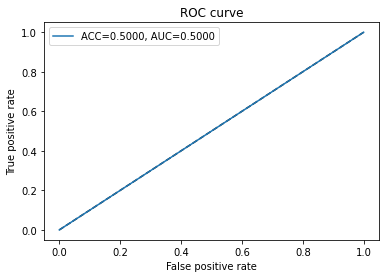

Classification Report
              precision    recall  f1-score   support

         neg       0.00      0.00      0.00      8000
         pos       0.50      1.00      0.67      8000

    accuracy                           0.50     16000
   macro avg       0.25      0.50      0.33     16000
weighted avg       0.25      0.50      0.33     16000

[[8000    0]
 [8000    0]]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 432x288 with 0 Axes>

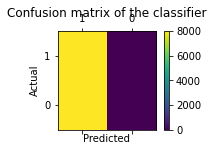

In [79]:

calc_and_print_metric_report(model_vgg, img_flow_val)

In [80]:
hist_records = {}

Approach:  Isolate query params and compare differences from tuning them

In [81]:
# accuracy getting around .85 for both, would like to see more epoch cycles since cropped images seem to be learning slower but attaining similar accuracy.
print('Epoch Model METRICS FOR ORIGINAL IMAGES')
model_history_rand = compile_and_fit_model(model_rand, 7, img_flow_train, img_flow_val)
hist_records['original'] = model_history_rand
print(hist_records)

print('Epoch Model METRICS FOR CROPPED IMAGES')
model_history_rand_cr = compile_and_fit_model(model_rand_cr, 7, img_flow_train_cr, img_flow_val)
hist_records['original cropped'] = model_history_rand_1
print(hist_records)
calc_and_print_metric_report(model_history_rand_cr, img_flow_val)

Epoch Model METRICS FOR ORIGINAL IMAGES
Epoch 1/7
4500/4500 [==============================] - 535s 119ms/step - loss: 0.4399 - accuracy: 0.8023 - precision_m: 0.8023 - recall_m: 0.8023 - f1_m: 0.8023 - val_loss: 0.7134 - val_accuracy: 0.6424 - val_precision_m: 0.6424 - val_recall_m: 0.6424 - val_f1_m: 0.6424
Epoch 2/7
4500/4500 [==============================] - 481s 107ms/step - loss: 0.3503 - accuracy: 0.8520 - precision_m: 0.8520 - recall_m: 0.8520 - f1_m: 0.8520 - val_loss: 0.3744 - val_accuracy: 0.8451 - val_precision_m: 0.8451 - val_recall_m: 0.8451 - val_f1_m: 0.8451
Epoch 3/7
4500/4500 [==============================] - 431s 96ms/step - loss: 0.3233 - accuracy: 0.8651 - precision_m: 0.8651 - recall_m: 0.8651 - f1_m: 0.8651 - val_loss: 0.3040 - val_accuracy: 0.8822 - val_precision_m: 0.8822 - val_recall_m: 0.8822 - val_f1_m: 0.8822
Epoch 4/7
4500/4500 [==============================] - 430s 96ms/step - loss: 0.3057 - accuracy: 0.8735 - precision_m: 0.8735 - recall_m: 0.8735 - f

AttributeError: ignored

Model Accuracy: 0.891.
(16000,)
Model AUC: 0.968.


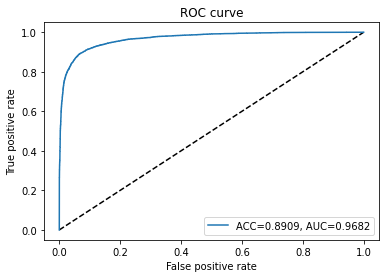

Classification Report
              precision    recall  f1-score   support

         neg       0.84      0.97      0.90      8000
         pos       0.96      0.81      0.88      8000

    accuracy                           0.89     16000
   macro avg       0.90      0.89      0.89     16000
weighted avg       0.90      0.89      0.89     16000

[[6493 1507]
 [ 238 7762]]


<Figure size 432x288 with 0 Axes>

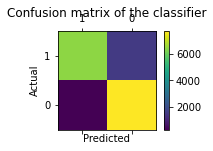

[0.8022639155387878, 0.8520277738571167, 0.8651041388511658, 0.8734722137451172, 0.8798263669013977, 0.8856666684150696, 0.8906458616256714]
[0.6424444317817688, 0.8451111316680908, 0.8822222352027893, 0.7984444499015808, 0.8844444155693054, 0.8948888778686523, 0.8886666893959045]


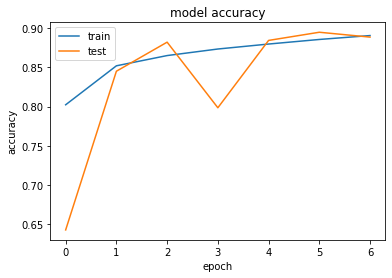

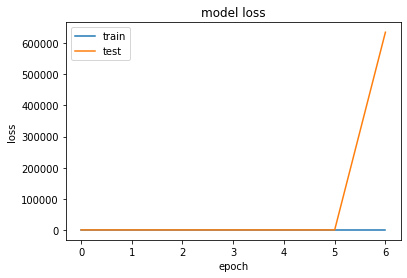

Epoch Model METRICS FOR CROPPED IMAGES
Epoch 1/7
4500/4500 [==============================] - 444s 99ms/step - loss: 0.4849 - accuracy: 0.7764 - precision_m: 0.7764 - recall_m: 0.7764 - f1_m: 0.7764 - val_loss: 0.7459 - val_accuracy: 0.5296 - val_precision_m: 0.5296 - val_recall_m: 0.5296 - val_f1_m: 0.5296
Epoch 2/7
4500/4500 [==============================] - 427s 95ms/step - loss: 0.4668 - accuracy: 0.7867 - precision_m: 0.7867 - recall_m: 0.7867 - f1_m: 0.7867 - val_loss: 1.1634 - val_accuracy: 0.5038 - val_precision_m: 0.5038 - val_recall_m: 0.5038 - val_f1_m: 0.5038
Epoch 3/7
4500/4500 [==============================] - 426s 95ms/step - loss: 0.4579 - accuracy: 0.7924 - precision_m: 0.7924 - recall_m: 0.7924 - f1_m: 0.7924 - val_loss: 1.0688 - val_accuracy: 0.5118 - val_precision_m: 0.5118 - val_recall_m: 0.5118 - val_f1_m: 0.5118
Epoch 4/7
4500/4500 [==============================] - 427s 95ms/step - loss: 0.4509 - accuracy: 0.7963 - precision_m: 0.7963 - recall_m: 0.7963 - f1_m

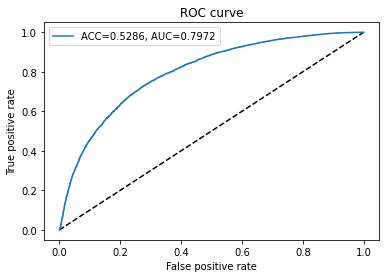

Classification Report
              precision    recall  f1-score   support

         neg       0.51      0.99      0.68      8000
         pos       0.86      0.07      0.13      8000

    accuracy                           0.53     16000
   macro avg       0.69      0.53      0.40     16000
weighted avg       0.69      0.53      0.40     16000

[[ 546 7454]
 [  88 7912]]


<Figure size 432x288 with 0 Axes>

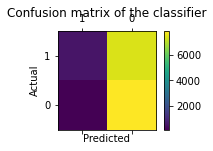

[0.8022639155387878, 0.8520277738571167, 0.8651041388511658, 0.8734722137451172, 0.8798263669013977, 0.8856666684150696, 0.8906458616256714]
[0.6424444317817688, 0.8451111316680908, 0.8822222352027893, 0.7984444499015808, 0.8844444155693054, 0.8948888778686523, 0.8886666893959045]


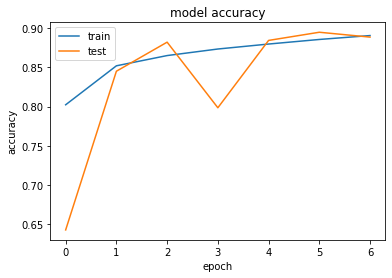

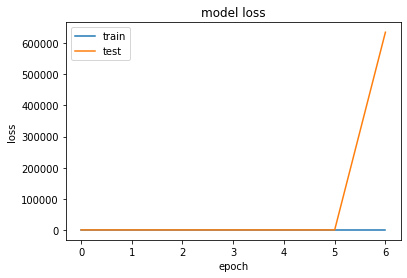

In [85]:
calc_and_print_metric_report(model_rand, img_flow_val)
plotForOverfitting(model_history_rand.history)

print('Epoch Model METRICS FOR CROPPED IMAGES')
model_history_rand_cr = compile_and_fit_model(model_rand_cr, 7, img_flow_train_cr, img_flow_val)
hist_records['original cropped'] = model_history_rand_cr
print(hist_records)
calc_and_print_metric_report(model_rand_cr, img_flow_val)
plotForOverfitting(model_history_rand.history)

In [86]:
# orig_history = {'loss': [0.4624, 0.3874, 0.3527, 0.3321], 'accuracy': [0.7916, 0.8330, 0.8497, 0.8618], 'val_loss': [0.3988, 9095.1631, 0.5628, 0.6675], 'val_accuracy': [0.8182, 0.8522, 0.7600, 0.7956], 'val_precision': [0.8182, 0.8522, 0.7600, 0.7956]}

In [87]:
# orig_cr_history = {'loss': [0.5428, 0.4950, 0.4733, 0.4606, 0.4524, 0.4457, 0.4382], 'accuracy': [0.7416, 0.7725, 0.7844, 0.7914, 0.7964, 0.8003, 0.8033], 'val_loss': [0.7001, 0.9596, 0.7590, 0.5780, 0.6999, 0.7938, 0.7439], 'val_accuracy': [0.5471, 0.5067, 0.5527, 0.6631, 0.5651, 0.5064, 0.5920], 'val_precision': []}

Finding the best performing model and seeing how tuning hyperparams effects it.

In [88]:
# turned down.  faster processing than the 5x5
# seems to result in lower accuracy.  would like to see more epoch cycles of this one
KERNEL_SIZE = (3, 3)

In [ ]:
model_init_rand_1 = keras.models.Sequential()
model_rand_1 = buildNewCNNRandom(model_init_rand_1, NODE_SIZE, KERNEL_SIZE, DROPOUT_PROBABILITY_CONV_LAYER, IMAGE_SHAPE, FINAL_DENSITY, MODEL_STRIDES,
MODEL_ACTIVATION, MODEL_MAXPOOL)
print('Epoch Model METRICS FOR CROPPED IMAGES')
model_history_rand_1_cr = compile_and_fit_model(model_rand_1, 7, img_flow_train_cr, img_flow_val)
hist_records['Lowered Kernel'] = model_history_rand_1
print(hist_records)
calc_and_print_metric_report(model_rand_1, img_flow_val)
plotForOverfitting(model_history_rand_1_cr.history)

Epoch Model METRICS FOR CROPPED IMAGES
Epoch 1/7
2869/4500 [==================>...........] - ETA: 2:20 - loss: 0.5513 - accuracy: 0.7358 - precision_m: 0.7358 - recall_m: 0.7358 - f1_m: 0.7358

In [ ]:
# trial1_cr_history = {'loss': [0.5460, 0.4966, 0.4834, 0.4723, 0.4626, 0.4568], 'accuracy': [0.7383, 0.7710, 0.7781, 0.7829, 0.7875, 0.7915], 'val_loss': [1.1415, 1979.0341, 0.8536, 16.8284, 1408416.6250, 23.7701], 'val_accuracy': [0.5971, 0.5653, 0.6071, 0.6069, 0.5976, 0.6764]}

In [ ]:
model_init_rand_1 = keras.models.Sequential()
model_rand_1 = buildNewCNNRandom(model_init_rand_1, NODE_SIZE, KERNEL_SIZE, DROPOUT_PROBABILITY_CONV_LAYER, IMAGE_SHAPE, FINAL_DENSITY, MODEL_STRIDES,
MODEL_ACTIVATION, MODEL_MAXPOOL)
print('Epoch Model METRICS FOR ORIGINAL IMAGES')
model_history_rand_1 = compile_and_fit_model(model_rand_1, 7, img_flow_train, img_flow_val)
hist_records['Lowered Kernel'] = model_history_rand_1
print(hist_records)
calc_and_print_metric_report(model_rand_1, img_flow_val)
plotForOverfitting(model_history_rand_1.history)

In [ ]:
# turned down.
KERNEL_SIZE = (5, 5)
# turned down.
# lowering the dropout probability is showing some improvements.  adding more epoch cycles to see more.  adding a similar step to reduce it more and observe.
DROPOUT_PROBABILITY_CONV_LAYER = 0.3
# turned down.
DROPOUT_PROBABILITY_DENSITY = 0.3

In [ ]:
model_init_rand_2_cr = keras.models.Sequential()
model_rand_2_cr = buildNewCNNRandom(model_init_rand_2, NODE_SIZE, KERNEL_SIZE, DROPOUT_PROBABILITY_CONV_LAYER, IMAGE_SHAPE, FINAL_DENSITY, MODEL_STRIDES,
MODEL_ACTIVATION, MODEL_MAXPOOL)
print('Epoch Model METRICS FOR CROPPED IMAGES')
model_history_rand_2_cr = compile_and_fit_model(model_rand_2_cr, 7, img_flow_train_cr, img_flow_val)
hist_records['Lowered Dropout Probability'] = model_history_rand_2_cr
print(hist_records)
calc_and_print_metric_report(model_init_rand_2, img_flow_val)
plotForOverfitting(model_history_rand_2_cr.history)

In [ ]:
model_init_rand_2 = keras.models.Sequential()
model_rand_2 = buildNewCNNRandom(model_init_rand_2, NODE_SIZE, KERNEL_SIZE, DROPOUT_PROBABILITY_CONV_LAYER, IMAGE_SHAPE, FINAL_DENSITY, MODEL_STRIDES,
MODEL_ACTIVATION, MODEL_MAXPOOL)
print('Epoch Model METRICS FOR ORIGINAL IMAGES')
model_history_rand_2 = compile_and_fit_model(model_rand_2, 7, img_flow_train, img_flow_val)
hist_records['Lowered Dropout Probability'] = model_history_rand_2
print(hist_records)
calc_and_print_metric_report(model_init_rand_2, img_flow_val)
plotForOverfitting(model_history_rand_2.history)

In [ ]:
# reducing dropout probability further
DROPOUT_PROBABILITY_CONV_LAYER = 0.2
# turned down.
DROPOUT_PROBABILITY_DENSITY = 0.2
model_init_rand_3_cr = keras.models.Sequential()
model_rand_3_cr = buildNewCNNRandom(model_init_rand_3_cr, NODE_SIZE, KERNEL_SIZE, DROPOUT_PROBABILITY_CONV_LAYER, IMAGE_SHAPE, FINAL_DENSITY, MODEL_STRIDES,
MODEL_ACTIVATION, MODEL_MAXPOOL)
print('Epoch Model METRICS FOR CROPPED IMAGES')
model_history_rand_3_cr = compile_and_fit_model(model_rand_3_cr, 7, img_flow_train_cr, img_flow_val)
hist_records['Lowered Dropout Probability'] = model_history_rand_3_cr
print(hist_records)
calc_and_print_metric_report(model_init_rand_3_cr, img_flow_val)
plotForOverfitting(model_history_rand_3_cr.history)

In [ ]:
# reducing dropout probability further
DROPOUT_PROBABILITY_CONV_LAYER = 0.2
# turned down.
DROPOUT_PROBABILITY_DENSITY = 0.2
model_init_rand_3 = keras.models.Sequential()
model_rand_3 = buildNewCNNRandom(model_init_rand_3, NODE_SIZE, KERNEL_SIZE, DROPOUT_PROBABILITY_CONV_LAYER, IMAGE_SHAPE, FINAL_DENSITY, MODEL_STRIDES,
MODEL_ACTIVATION, MODEL_MAXPOOL)
print('Epoch Model METRICS FOR ORIGINAL IMAGES')
model_history_rand_3 = compile_and_fit_model(model_rand_3, 7, img_flow_train, img_flow_val)
hist_records['Lowered Dropout Probability'] = model_history_rand_3
print(hist_records)
calc_and_print_metric_report(model_init_rand_3, img_flow_val)
plotForOverfitting(model_history_rand_3.history)

In [ ]:
# turning dropout rate way up
DROPOUT_PROBABILITY_CONV_LAYER = 0.7
# turned up.
DROPOUT_PROBABILITY_DENSITY = 0.7
model_init_rand_4_cr = keras.models.Sequential()
model_rand_4_cr = buildNewCNNRandom(model_init_rand_4_cr, NODE_SIZE, KERNEL_SIZE, DROPOUT_PROBABILITY_CONV_LAYER, IMAGE_SHAPE, FINAL_DENSITY, MODEL_STRIDES,
MODEL_ACTIVATION, MODEL_MAXPOOL)
print('Epoch Model METRICS FOR CROPPED IMAGES')
model_history_rand_4_cr = compile_and_fit_model(model_rand_4_cr, 7, img_flow_train_cr, img_flow_val)
hist_records['Lowered Dropout Probability'] = model_history_rand_2
print(hist_records)
calc_and_print_metric_report(model_init_rand_4_cr, img_flow_val)
plotForOverfitting(model_history_rand_4_cr.history)

In [ ]:
# turning dropout rate way up
DROPOUT_PROBABILITY_CONV_LAYER = 0.7
# turned up.
DROPOUT_PROBABILITY_DENSITY = 0.7
model_init_rand_4 = keras.models.Sequential()
model_rand_4 = buildNewCNNRandom(model_init_rand_4, NODE_SIZE, KERNEL_SIZE, DROPOUT_PROBABILITY_CONV_LAYER, IMAGE_SHAPE, FINAL_DENSITY, MODEL_STRIDES,
MODEL_ACTIVATION, MODEL_MAXPOOL)
print('Epoch Model METRICS FOR ORIGINAL IMAGES')
model_history_rand_4 = compile_and_fit_model(model_rand_4, 7, img_flow_train, img_flow_val)
hist_records['Lowered Dropout Probability'] = model_history_rand_4
print(hist_records)
calc_and_print_metric_report(model_init_rand_4, img_flow_val)
plotForOverfitting(model_history_rand_4.history)

In [ ]:
DROPOUT_PROBABILITY_CONV_LAYER = 0.5
# turned down.
DROPOUT_PROBABILITY_DENSITY = 0.5
# default is 2 x 2.
MODEL_MAXPOOL = (3, 3)

In [ ]:
# updating to (3, 3) didn't produce any meaningful improvements, so upping to (5, 5) to see if anything is evident.
MODEL_MAXPOOL = (5, 5)
model_init_rand_5_cr = keras.models.Sequential()
model_rand_5_cr = buildNewCNNRandom(model_init_rand_5_cr, NODE_SIZE, KERNEL_SIZE, DROPOUT_PROBABILITY_CONV_LAYER, IMAGE_SHAPE, FINAL_DENSITY, MODEL_STRIDES,
MODEL_ACTIVATION, MODEL_MAXPOOL)
print('Epoch Model METRICS FOR CROPPED IMAGES')
model_history_rand_5_cr = compile_and_fit_model(model_rand_5_cr, 7, img_flow_train_cr, img_flow_val)
hist_records['Max Pool Increase'] = model_history_rand_5_cr
print(hist_records)
calc_and_print_metric_report(model_init_rand_5_cr, img_flow_val)
plotForOverfitting(model_history_rand_5_cr.history)

In [ ]:
# updating to (3, 3) didn't produce any meaningful improvements, so upping to (5, 5) to see if anything is evident.
MODEL_MAXPOOL = (5, 5)
model_init_rand_5 = keras.models.Sequential()
model_rand_5 = buildNewCNNRandom(model_init_rand_5, NODE_SIZE, KERNEL_SIZE, DROPOUT_PROBABILITY_CONV_LAYER, IMAGE_SHAPE, FINAL_DENSITY, MODEL_STRIDES,
MODEL_ACTIVATION, MODEL_MAXPOOL)
print('Epoch Model METRICS FOR ORIGINAL IMAGES')
model_history_rand_5 = compile_and_fit_model(model_rand_5, 7, img_flow_train, img_flow_val)
hist_records['Max Pool Increase'] = model_history_rand_5
print(hist_records)
calc_and_print_metric_report(model_init_rand_5, img_flow_val)
plotForOverfitting(model_history_rand_5.history)

In [ ]:
MODEL_MAXPOOL = (2, 2)
# up by .01
LEARNING_RATE = 0.02
# maybe update this to (32, 64, 128, 256, 512)
# NODE_SIZE = (16, 32, 64, 128, 256)

In [ ]:
# accuracy seems to be going down judging by a few samples.
model_init_rand_6_cr = keras.models.Sequential()
model_rand_6_cr = buildNewCNNRandom(model_init_rand_6_cr, NODE_SIZE, KERNEL_SIZE, DROPOUT_PROBABILITY_CONV_LAYER, IMAGE_SHAPE, FINAL_DENSITY, MODEL_STRIDES,
MODEL_ACTIVATION, MODEL_MAXPOOL)
print('Epoch Model METRICS FOR CROPPED IMAGES')
model_history_rand_6_cr = compile_and_fit_model(model_rand_6_cr, 3, img_flow_train_cr, img_flow_val)
hist_records['Learning Rate Slight Increase'] = model_history_rand_6_cr
print(hist_records)
calc_and_print_metric_report(model_init_rand_6_cr, img_flow_val)
plotForOverfitting(model_history_rand_6_cr.history)

In [ ]:
# accuracy seems to be going down judging by a few samples.
model_init_rand_6 = keras.models.Sequential()
model_rand_6 = buildNewCNNRandom(model_init_rand_6, NODE_SIZE, KERNEL_SIZE, DROPOUT_PROBABILITY_CONV_LAYER, IMAGE_SHAPE, FINAL_DENSITY, MODEL_STRIDES,
MODEL_ACTIVATION, MODEL_MAXPOOL)
print('Epoch Model METRICS FOR ORIGINAL IMAGES')
model_history_rand_6 = compile_and_fit_model(model_rand_6, 3, img_flow_train, img_flow_val)
hist_records['Learning Rate Slight Increase'] = model_history_rand_6
print(hist_records)
calc_and_print_metric_report(model_init_rand_6, img_flow_val)
plotForOverfitting(model_history_rand_6 .history)

In [ ]:
# this is heading in the right direction with learning rate = .06, and accuracy .5453 after 3 cycles.  .8575 though exists with the lr as .01 so moving closer to .1
LEARNING_RATE = 0.1
model_init_rand_7 = keras.models.Sequential()
model_rand_7 = buildNewCNNRandom(model_init_rand_7, NODE_SIZE, KERNEL_SIZE, DROPOUT_PROBABILITY_CONV_LAYER, IMAGE_SHAPE, FINAL_DENSITY, MODEL_STRIDES,
MODEL_ACTIVATION, MODEL_MAXPOOL)
print('Epoch Model METRICS FOR ORIGINAL IMAGES')
model_history_rand_7 = compile_and_fit_model(model_rand_7, 3, img_flow_train, img_flow_val)
hist_records['Learning Rate Significant Increase'] = model_history_rand_7
print(hist_records)
calc_and_print_metric_report(model_init_rand_7, img_flow_val)
plotForOverfitting(model_history_rand_7.history)

In [ ]:

model_init_rand_7_cr = keras.models.Sequential()
model_rand_7_cr = buildNewCNNRandom(model_init_rand_7, NODE_SIZE, KERNEL_SIZE, DROPOUT_PROBABILITY_CONV_LAYER, IMAGE_SHAPE, FINAL_DENSITY, MODEL_STRIDES,
MODEL_ACTIVATION, MODEL_MAXPOOL)
print('Epoch Model METRICS FOR CROPPED IMAGES')
model_history_rand_7_cr = compile_and_fit_model(model_rand_7_cr, 3, img_flow_train_cr, img_flow_val)
hist_records['Learning Rate Significant Increase'] = model_history_rand_7_cf
print(hist_records)
calc_and_print_metric_report(model_init_rand_7, img_flow_val)
plotForOverfitting(model_history_rand_7_cr.history)

In [ ]:
LEARNING_RATE = 0.005
model_init_rand_8_cr = keras.models.Sequential()
model_rand_8_cr = buildNewCNNRandom(model_init_rand_8_cr, NODE_SIZE, KERNEL_SIZE, DROPOUT_PROBABILITY_CONV_LAYER, IMAGE_SHAPE, FINAL_DENSITY, MODEL_STRIDES,
MODEL_ACTIVATION, MODEL_MAXPOOL)
print('Epoch Model METRICS FOR CROPPED IMAGES')
model_history_rand_8_cr = compile_and_fit_model(model_rand_8_cr, 3, img_flow_train_cr, img_flow_val)
hist_records['Learning Rate Slight Decrease'] = model_history_rand_8_cr
print(hist_records)
calc_and_print_metric_report(model_init_rand_8_cr, img_flow_val)
plotForOverfitting(model_history_rand_8_cr.history)

In [ ]:
model_init_rand_8 = keras.models.Sequential()
model_rand_8 = buildNewCNNRandom(model_init_rand_8, NODE_SIZE, KERNEL_SIZE, DROPOUT_PROBABILITY_CONV_LAYER, IMAGE_SHAPE, FINAL_DENSITY, MODEL_STRIDES,
MODEL_ACTIVATION, MODEL_MAXPOOL)
print('Epoch Model METRICS FOR ORIGINAL IMAGES')
model_history_rand_8 = compile_and_fit_model(model_rand_8, 3, img_flow_train, img_flow_val)
hist_records['Learning Rate Slight Decrease'] = model_history_rand_8
print(hist_records)
calc_and_print_metric_report(model_init_rand_8, img_flow_val)
plotForOverfitting(model_history_rand_8.history)

In [ ]:
# TODO: combo of a successful improvement from queryparam tuning or two or three..

# .82

Configurable params and hyperparams.

of images.  Sweet Spot where having more isn't better.
topology of the image data.  split into datasets where pos/neg have equal amounts.  split label dataset which maps to train dataset into training and testing data, then later we will use the test images for the submission predictions.

optimizable:  learning rate set initially to .1.  using a callback for optimization of this during multiple epoch runs.

handle overfitting:  

by removing layers or reducing the number of elements in the hidden layers
-- by lowering the # of nodes:  By lowering the capacity of the network, you force it to learn the patterns that matter or that minimize the loss.
-- reducing the network’s capacity too much will lead to underfitting. The model will not be able to learn the relevant patterns in the train data.
-- To address overfitting, we can apply weight regularization to the model. This will add a cost to the loss function of the network for large weights (or parameter values). As a result, you get a simpler model that will be forced to learn only the relevant patterns in the train data.




Use Dropout layers, which will randomly remove certain features by setting them to zero


augmentation of images - done.
ways to avoid overfitting.
model layers and params.

ways to tune hyperparameters

architecture isn't a science it is an art.  why, why not, based on popular approaches.

when to use 

max pooling - todo.
dropouts.

filter size. - 
stride size. - 
kernel size - sometimes smaller ones are faster, like with resnet.

shuffle data?

Choosing an optimizer and a loss function - binary? crossentropy.

## Define Architectural Configuration

In [ ]:
# given config params and possible range
# set up routine as a function (building data, setting images and model up, calling fit.)
#.   define callback to reference a max accuracy value
# generate config permutations
# iterate through permutations calling routine, only continue with iteration if max accuracy is exceeded.

## Build, Compile, and Fit CNN

## Metric Analysis Data Viz on Performance

Display the Confusion Matrix and Classification Reports for the model.

In [ ]:
calc_and_print_metric_report(model_cr, img_flow_val)

## Submission

In [ ]:
test_df = pd.read_csv(sample_submission)
from glob import glob

TESTING_BATCH_SIZE = 64
# get test files
testing_files = glob(os.path.join(input_test,'*.tif'))
# create empty pandas dataframe
submission = pd.DataFrame()
print(len(testing_files))
# 10 should be: len(testing_files)
for index in range(0, len(testing_files), TESTING_BATCH_SIZE):
    data_frame = pd.DataFrame({'path': testing_files[index:index+TESTING_BATCH_SIZE]})
    # parse in IDs and Images for each test file item
    data_frame['id'] = data_frame.path.map(lambda x: x.split('/')[3].split(".")[0])
    data_frame['image'] = data_frame['path'].map(imread)
    # join image array
    images = np.stack(data_frame.image, axis=0)
    ids = np.stack(data_frame.id, axis=0)
    # expand dims restructures shape for the image in precitions by expanding it.
    predicted_labels = [model.predict(np.expand_dims(image/255.0, axis=0))[0][0] for image in images]
    # make a prediction array
    predictions = np.array(predicted_labels)
    # assign predictions to a new label column in the df
    data_frame['label'] = predictions
    # can remove this for actual submission, this is more for metric data vis.
    # add frame to existing submission df
    submission = pd.concat([submission, data_frame[["id", "label"]]])
    # mark the passing of time with a log
    if index % 1000 == 0 :
        print(index/len(testing_files) * 100)
# convert the submission to a csv
submission.to_csv('submission_aug_v4.csv', index=False, header=True)
print(submission.head())

In [ ]:
!cp submission_aug_v4.csv "drive/My Drive/"   


In [ ]:
# modularize the submission code.
# get prediction labels from df.
# get classes.
# pass to metric data vis module.

refs: 
https://androidkt.com/get-the-roc-curve-and-auc-for-keras-model/

https://tduan.netlify.app/post/ai-from-the-data-center-to-the-edge-training-by-intel/part3-model_analysis

In [ ]:
# max: 0.9179 on non cropped images.
# .86/ 20 epoch with cropped images and standard.
# .599/ 20 cropped and nonstandard.

In [ ]:
# metrics:  https://towardsdatascience.com/the-5-classification-evaluation-metrics-you-must-know-aa97784ff226
# accuracy, precision, recall.
# f1, log loss (specific for binary classification), auc

# howto?  calc myself or use classificationReport from scikit
# https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model
# https://keras.io/api/metrics/accuracy_metrics/#binaryaccuracy-class